# **Wallmart Sales Projection Using Time Series Analysis**

### a. **Problem Statement**

A retail store that has multiple outlets across the country are facing issues in managing the
inventory - to match the demand with respect to supply.


### b. **Project Objective**

To build useful insights using the data and make prediction models to forecast the sales for
X number of months/years

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#import specific forecasting tools

from statsmodels.tsa.seasonal import seasonal_decompose # to plot components of time series
from statsmodels.tsa.statespace.tools import diff

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

from statsmodels.tsa.arima_model import *

In [17]:
#Converting Datatype of Date Column to DateTime and Seting it as Index Column
data = pd.read_csv('Walmart.csv', parse_dates=['Date'], index_col= 'Date')

### c. **EDA**

In [18]:
data.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2010-05-02,1,1643690.90,0,42.31,2.572,211.096358,8.106
2010-12-02,1,1641957.44,1,38.51,2.548,211.242170,8.106
2010-02-19,1,1611968.17,0,39.93,2.514,211.289143,8.106
2010-02-26,1,1409727.59,0,46.63,2.561,211.319643,8.106
2010-05-03,1,1554806.68,0,46.50,2.625,211.350143,8.106


In [19]:
data.shape  #We have 6435 Rows and 7 Columns

(6435, 7)

In [20]:
data.info()   #Data Types are Correcctly Attributed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6435 entries, 2010-05-02 to 2012-10-26
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Weekly_Sales  6435 non-null   float64
 2   Holiday_Flag  6435 non-null   int64  
 3   Temperature   6435 non-null   float64
 4   Fuel_Price    6435 non-null   float64
 5   CPI           6435 non-null   float64
 6   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 402.2 KB


In [21]:
data.describe()   #Statistical Analysis of Data

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


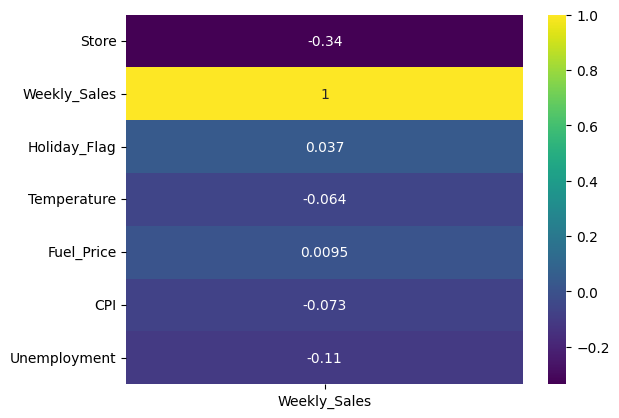

In [23]:
sns.heatmap(data.corr()[['Weekly_Sales']], cmap = 'viridis', annot=True); #Both Negative and Positive Correlations Exist in our data

**Duplicates**

In [24]:
data.duplicated().sum()  #No Duplicates

0

**Null Values**

In [26]:
data.isnull().sum()  #No Null Values

Store           0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

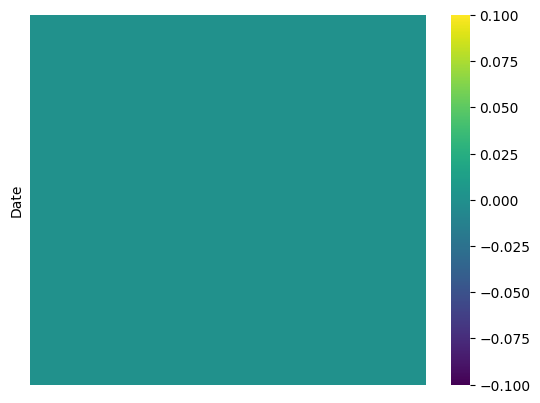

In [27]:
sns.heatmap(data.isnull(), yticklabels= False, xticklabels=False, cmap = 'viridis');
#Visualizing if null values are present

**Outliers**

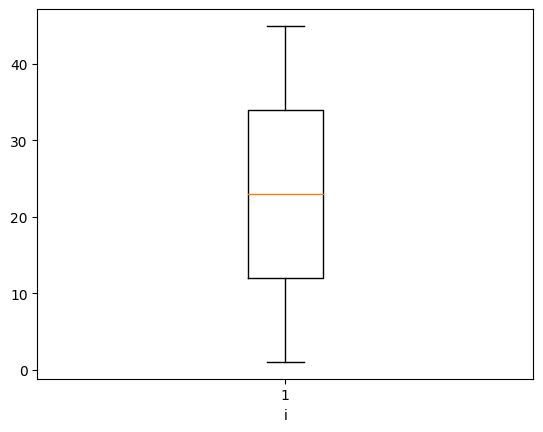

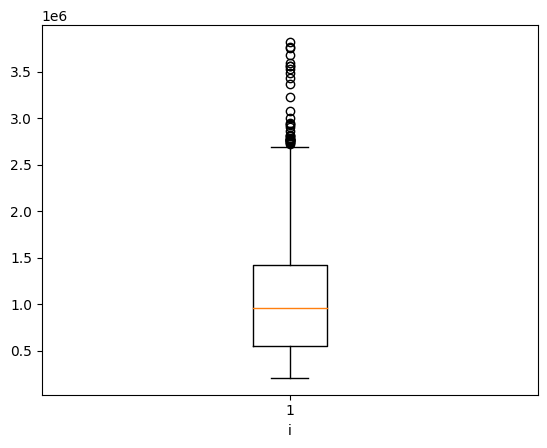

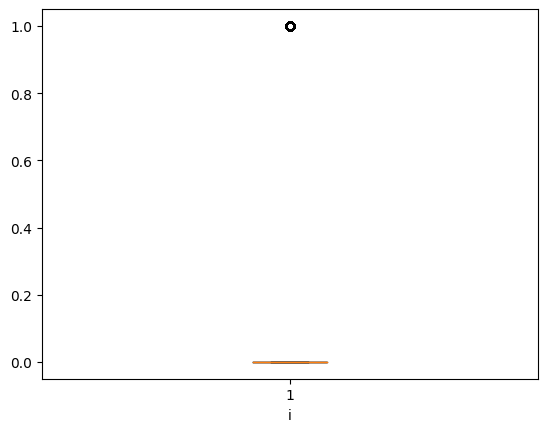

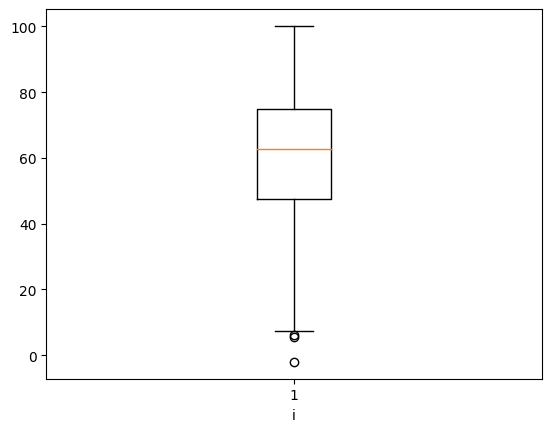

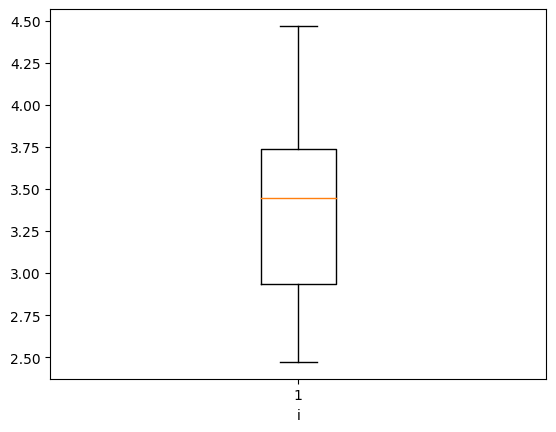

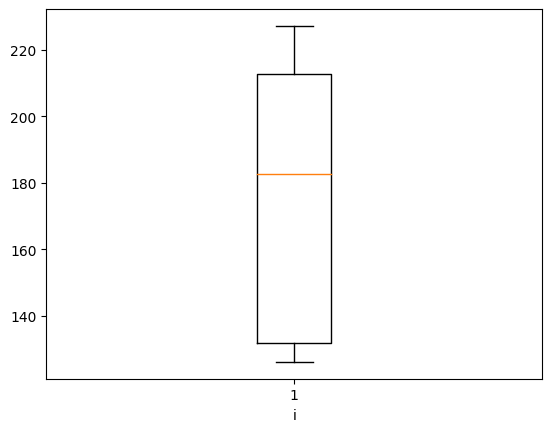

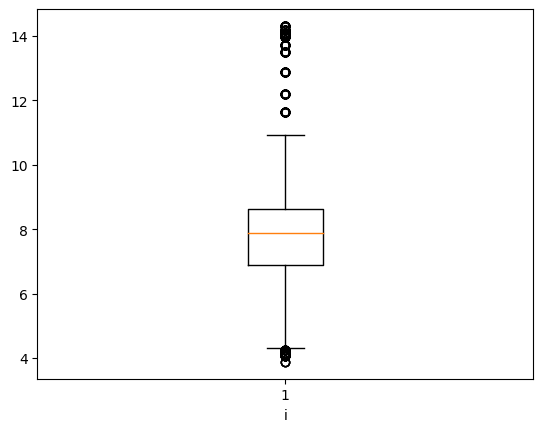

In [28]:
for i in data.columns:  #Since in time series it is not important to remove Outliers
  if data[i].dtypes != object:
    plt.boxplot(data[i])
    plt.xlabel('i')
    plt.show();

**Weekly Sales Distribution**

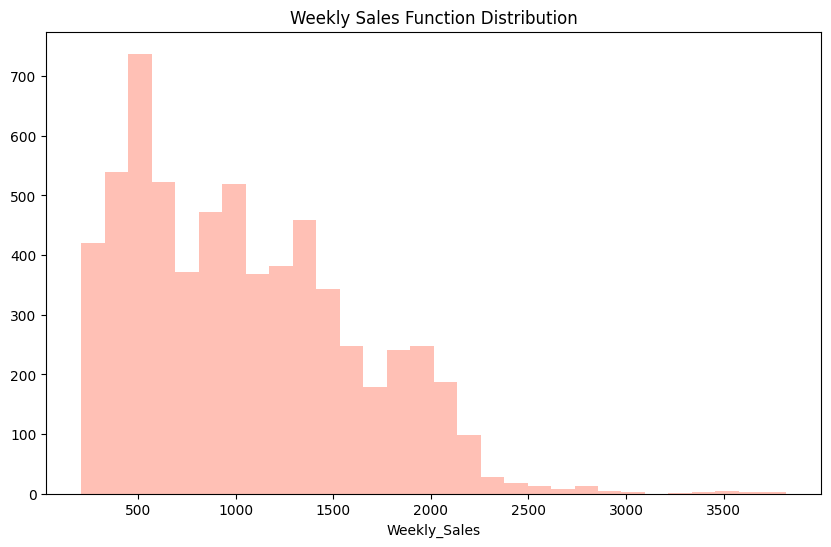

In [29]:
plt.figure(figsize=(10, 6))
data["Weekly_Sales"]=data.Weekly_Sales/1000
sns.distplot(data.Weekly_Sales, kde=False, bins=30, color = 'tomato')
plt.title('Weekly Sales Function Distribution')
plt.show()

In [37]:
data['Store'].unique()



array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

In [30]:
data.columns

Index(['Store', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price',
       'CPI', 'Unemployment'],
      dtype='object')

### d. **Data Pre Processing & Inspiration**

**Time Series**

Any data recorded with some fixed time interval is called time series data.

First we will Group Weekly Sales Data By Stores (1-45)

In [40]:
data.Store.nunique()

45

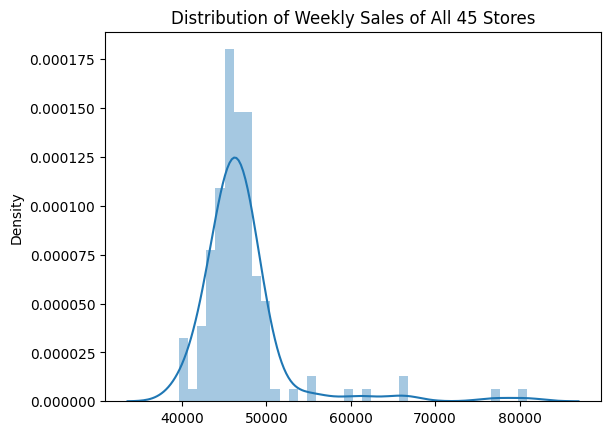

In [41]:
# There are about 45 different stores in this dataset.
plt.title('Distribution of Weekly Sales of All 45 Stores')
sales = pd.DataFrame(data.Weekly_Sales.groupby(data.Store.index).sum())
sns.distplot(sales);

#### **Data Sampling**

Since our data is quite big for analysis, We will consider few stores and perform a detailed time-series analysis on it

**Store 4**

In [42]:
store4 = data[data.Store == 4]

In [43]:
# Grouped weekly sales by store 4
sales4 = pd.DataFrame(store4.Weekly_Sales.groupby(store4.index).sum())
sales4.head(5)

,Weekly_Sales
Date,
2010-01-10,1842.82102
2010-02-04,1979.24712
2010-02-07,1881.33721
2010-02-19,2049.86026
2010-02-26,1925.72884


**Store 6**

In [44]:
store6 = data[data.Store == 6]

In [45]:
sales6 = pd.DataFrame(store6.Weekly_Sales.groupby(store6.index).sum())
sales6.head()

,Weekly_Sales
Date,
2010-01-10,1328.46889
2010-02-04,1770.33390
2010-02-07,1759.77725
2010-02-19,1567.13807
2010-02-26,1432.95321


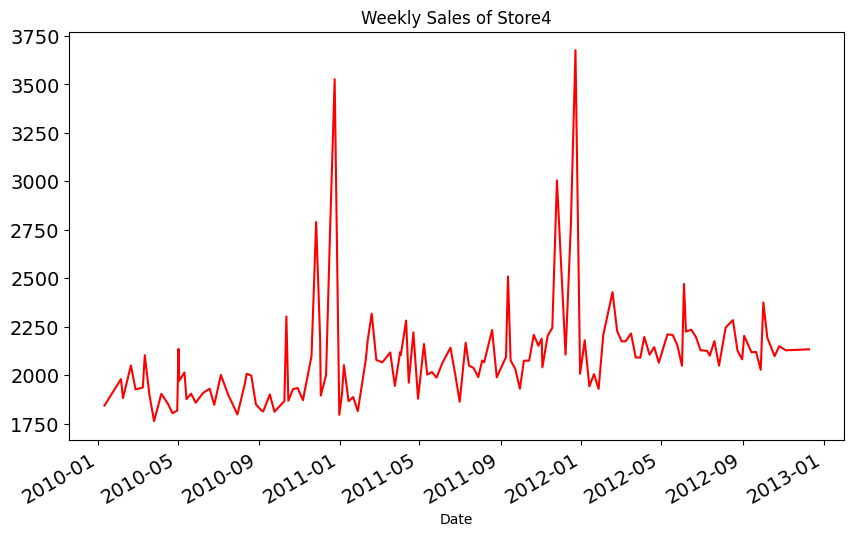

In [46]:
sales4.Weekly_Sales.plot(figsize=(10,6), title= 'Weekly Sales of Store4', fontsize=14, color = 'red')
plt.show()

### **Time Series Analysis**

Time Series Decomposition
to deconstruct the time series into several component like trend and seasonality for better visualization of its characteristics
We Have Two Models of Decompositions
1. Additive Model = useful when the seasonal variation is relatively constant over time.
2. Multipicative Model = useful when the seasonal variation increases over time

<Figure size 640x480 with 0 Axes>

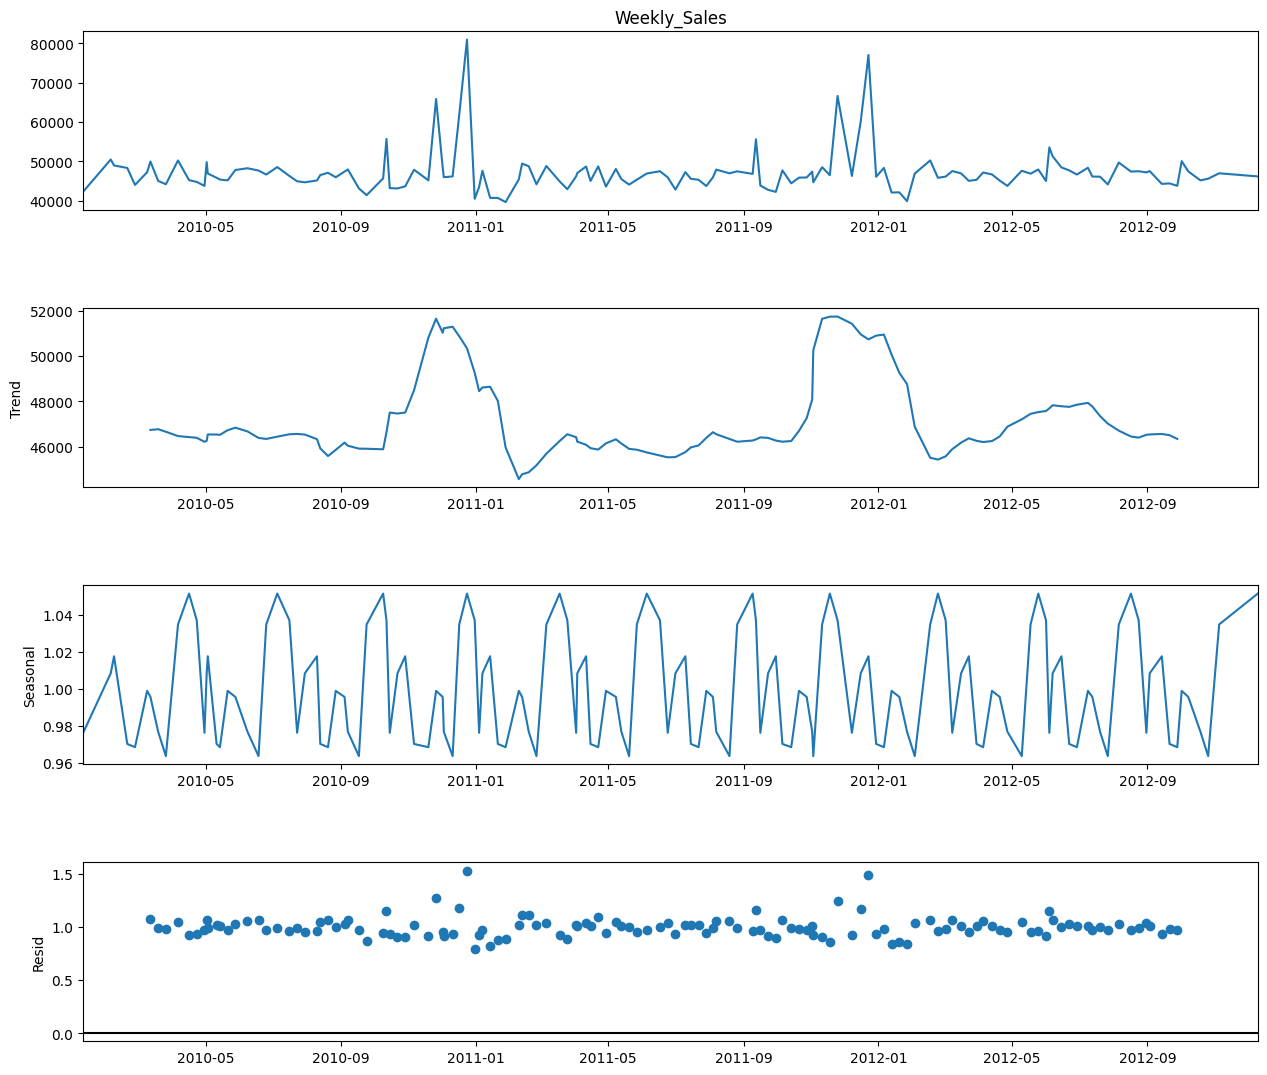

In [47]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(sales.Weekly_Sales, model= 'multiplicative', period=12)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(14, 12)
plt.show();

In [48]:
y1=sales4.Weekly_Sales
y2=sales6.Weekly_Sales

**Visual Check for Trend**

Trend represent the change in dependent variables with respect to time from start to end.
Trend has two Types
1. Increasing or Downward Trend
2. Decreasing or Downward Trend

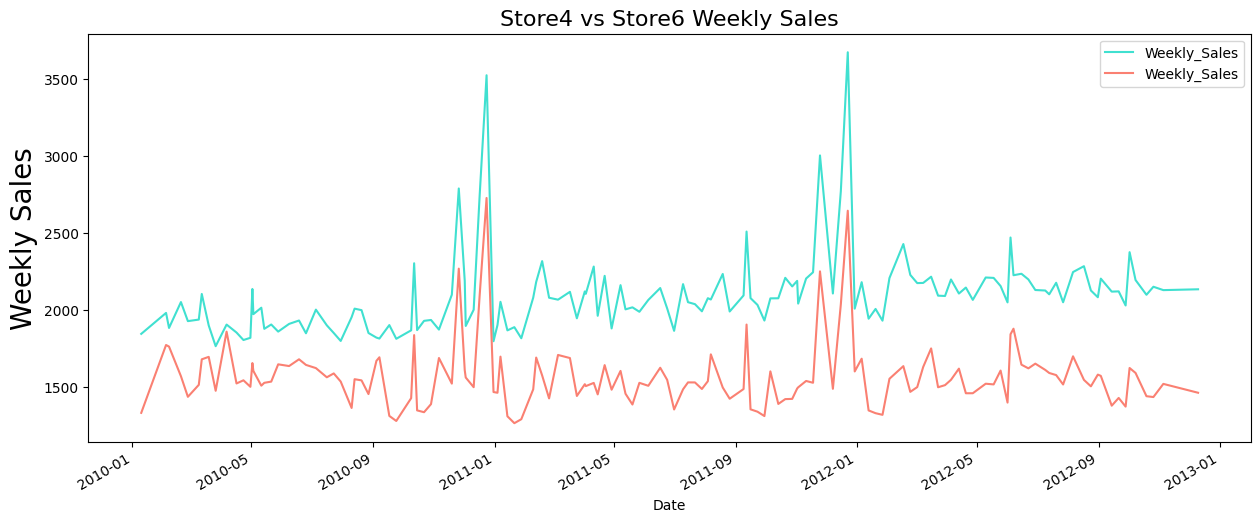

In [49]:
y1.plot(figsize=(15, 6), legend=True, color = 'turquoise')
y2.plot(figsize=(15, 6), legend=True, color = 'salmon')
plt.ylabel('Weekly Sales', fontsize = '20')
plt.title('Store4 vs Store6 Weekly Sales', fontsize = '16')
plt.show()

We can observe a trend during year ends (during both 2011 & 2012). The best thing is both the stores have almost the same trends and spike just the magnitude(size) is different.
This clearly tells its a timeseries problem and it will be interesting to look more into it

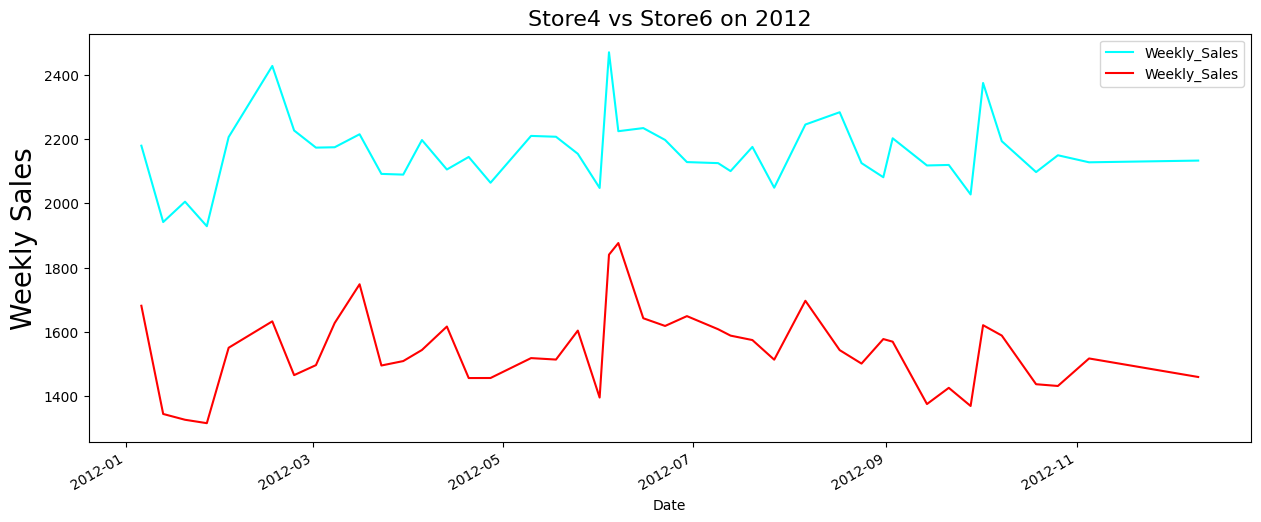

In [50]:
#lets compare the 2012 data of two stores (4 and 6)
y1['2012'].plot(figsize=(15, 6),legend=True, color = 'cyan')
y2['2012'].plot(figsize=(15, 6), legend=True, color = 'red')
plt.ylabel('Weekly Sales', fontsize = '20')
plt.title('Store4 vs Store6 on 2012', fontsize = '16')
plt.show()

**Visual Check for Irregularities**

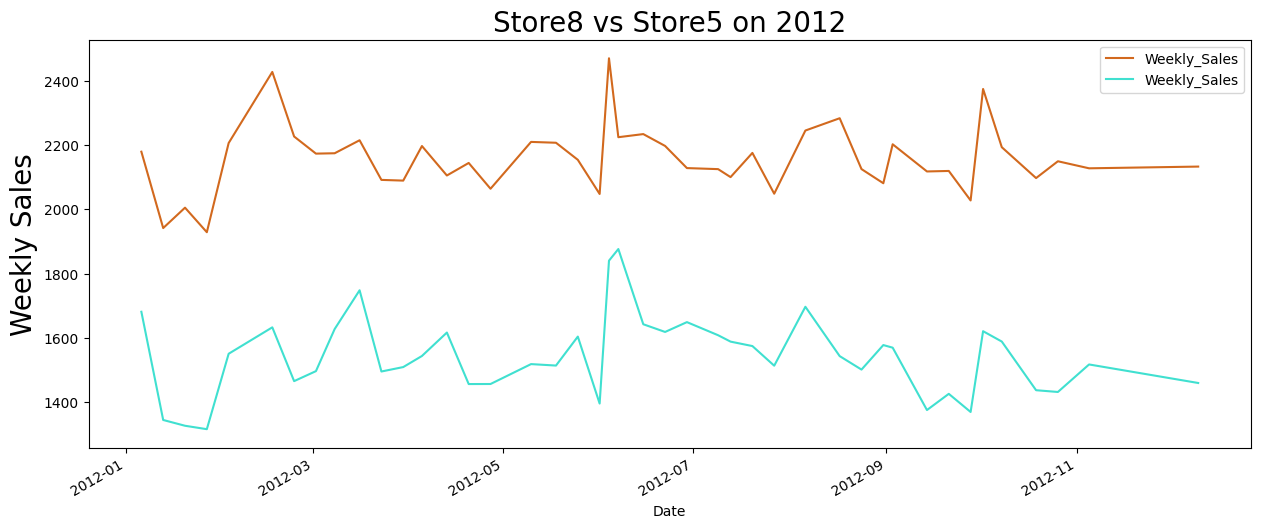

In [51]:
y1['2012'].plot(figsize=(15, 6),legend=True, color = 'chocolate')
y2['2012'].plot(figsize=(15, 6), legend=True, color = 'turquoise')
plt.ylabel('Weekly Sales', fontsize = '20')
plt.title('Store8 vs Store5 on 2012', fontsize = '20')
plt.show()

**Statistical Test for Data Stationarity**

In [53]:
#ad-fuller test (preffered)
from statsmodels.tsa.stattools import adfuller #p-value > 0.05: ---> not stationary / p-value <= 0.05: --> stationary
result = adfuller(data.Weekly_Sales)
print(result)
print('p-value: %f' % result[1]) #should be above critical value of 5% inorder to reject null hypothesis
print('ADF Statistic: %f' % result[0]) #should be negative inorder to reject null hypothesis
if result[1]>0.05:
  print('not stationary')
else:
  print("stationary")

(-4.624149498578308, 0.00011655869699901031, 34, 6400, {'1%': -3.4313721757424656, '5%': -2.8619917128968813, '10%': -2.5670104435791017}, 83103.0666094594)
p-value: 0.000117
ADF Statistic: -4.624149
stationary


### e. **Choosing Algorithm For Project**

**SARIMAX** Seasonal Arima

After a Clear Analysis and deep dive in our data, it is evident our Data has alot of irregulairities, Seasonality and Trend.
We Conclude that SARIMAX will be best fit for our Data because it will help with the issue of Seasonality
Also, Auto Arima predicted SARIMAX as the best Model for our Data

### f. **Motivation and Reasons for choosing the Algorithm**

We chose SARIMAX Algorithm to be the best fit on this particular Time Series Data.

Reason 1:
After Visualizing our data, the trends were visible at the end of the year and irregularities also existed.

Reason 2:
ARIMA can be Useful when data has trends only but our data had Seasonality so we chose SARIMAX.

Reason 3
The Secondary Reason being , SARIMAX was also suggested by Auto Arima

### g. **Assumptions**

* Sales seem to be the highest during the holiday season (in the months of November and December)
* Store size is still a great factor that affects sales; the bigger the store, the higher the sales. Store A still has the highest sales, followed by stores B and C
* Stores 4, 14, and 20 are the three stores with the highest sales; similar to this, other than store 14, stores 4 and 20 still have the highest predicted sales
* Departments 92, 95. 38, and 72 still have the highest sales for all three store types

### h. **Model Evaluation and Techniques**

**Defining PDQ**

Where

* P = number of autoregressive terms
* D = number of nonseasonal differences needed for stationarity
* Q = number of lagged forecast errors in the prediction equation.

In [54]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 5)
import itertools
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, d and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

In [55]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (0, 2, 4),
 (0, 3, 0),
 (0, 3, 1),
 (0, 3, 2),
 (0, 3, 3),
 (0, 3, 4),
 (0, 4, 0),
 (0, 4, 1),
 (0, 4, 2),
 (0, 4, 3),
 (0, 4, 4),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (1, 0, 4),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 3),
 (1, 2, 4),
 (1, 3, 0),
 (1, 3, 1),
 (1, 3, 2),
 (1, 3, 3),
 (1, 3, 4),
 (1, 4, 0),
 (1, 4, 1),
 (1, 4, 2),
 (1, 4, 3),
 (1, 4, 4),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (2, 0, 4),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2),
 (2, 2, 3),
 (2, 2, 4),
 (2, 3, 0),
 (2, 3, 1),
 (2, 3, 2),
 (2, 3, 3),
 (2, 3, 4),
 (2, 4, 0),
 (2, 4, 1),
 (2, 4, 2),
 (2, 4, 3),
 (2, 4, 4),
 (3, 0, 0),
 (3, 0, 1),
 (3, 0, 2),
 (3, 0, 3),
 (3, 0, 4),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3,

In [56]:
seasonal_pdq

[(0, 0, 0, 52),
 (0, 0, 1, 52),
 (0, 0, 2, 52),
 (0, 0, 3, 52),
 (0, 0, 4, 52),
 (0, 1, 0, 52),
 (0, 1, 1, 52),
 (0, 1, 2, 52),
 (0, 1, 3, 52),
 (0, 1, 4, 52),
 (0, 2, 0, 52),
 (0, 2, 1, 52),
 (0, 2, 2, 52),
 (0, 2, 3, 52),
 (0, 2, 4, 52),
 (0, 3, 0, 52),
 (0, 3, 1, 52),
 (0, 3, 2, 52),
 (0, 3, 3, 52),
 (0, 3, 4, 52),
 (0, 4, 0, 52),
 (0, 4, 1, 52),
 (0, 4, 2, 52),
 (0, 4, 3, 52),
 (0, 4, 4, 52),
 (1, 0, 0, 52),
 (1, 0, 1, 52),
 (1, 0, 2, 52),
 (1, 0, 3, 52),
 (1, 0, 4, 52),
 (1, 1, 0, 52),
 (1, 1, 1, 52),
 (1, 1, 2, 52),
 (1, 1, 3, 52),
 (1, 1, 4, 52),
 (1, 2, 0, 52),
 (1, 2, 1, 52),
 (1, 2, 2, 52),
 (1, 2, 3, 52),
 (1, 2, 4, 52),
 (1, 3, 0, 52),
 (1, 3, 1, 52),
 (1, 3, 2, 52),
 (1, 3, 3, 52),
 (1, 3, 4, 52),
 (1, 4, 0, 52),
 (1, 4, 1, 52),
 (1, 4, 2, 52),
 (1, 4, 3, 52),
 (1, 4, 4, 52),
 (2, 0, 0, 52),
 (2, 0, 1, 52),
 (2, 0, 2, 52),
 (2, 0, 3, 52),
 (2, 0, 4, 52),
 (2, 1, 0, 52),
 (2, 1, 1, 52),
 (2, 1, 2, 52),
 (2, 1, 3, 52),
 (2, 1, 4, 52),
 (2, 2, 0, 52),
 (2, 2, 1, 52),
 (2, 2, 

In [57]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(y1,
order=(4, 3, 1),
seasonal_order=(1, 4, 4, 52), #enforce_stationarity=False,
enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1              -0         -0        nan        nan           0          -0
ar.L2              -0         -0        nan        nan           0          -0
ar.L3               0         -0        nan        nan           0           0
ar.L4               0         -0        nan        nan           0           0
ma.L1               0         -0        nan        nan           0           0
ar.S.L52            0         -0        nan        nan           0           0
ma.S.L52            0         -0        nan        nan           0           0
ma.S.L104           0         -0        nan        nan           0           0
ma.S.L156           0         -0        nan        nan           0           0
ma.S.L208           0         -0        nan        nan           0           0
sigma2         1.0000         -0       -inf      0.0

**Prediction For Last 90 Days**

In [58]:
pred = results.get_prediction(start=pd.to_datetime('2012-07-27'), dynamic=False)
pred_ci = pred.conf_int()

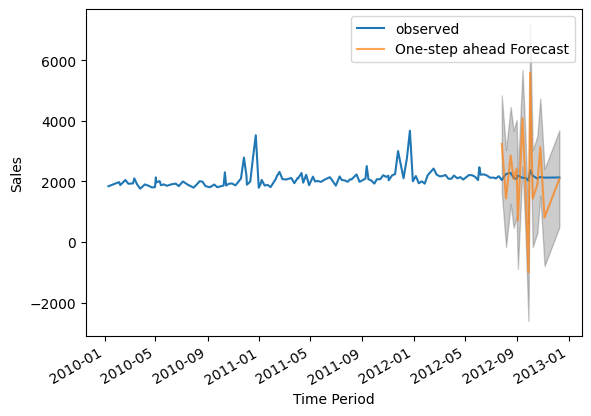

In [59]:
ax = y1['2010':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
pred_ci.iloc[:, 0],
pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Time Period')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

In [60]:
y_forecasted = pred.predicted_mean
y_truth = y1['2012-7-27':]
# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 2105184.49


In [61]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2012-7-27'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

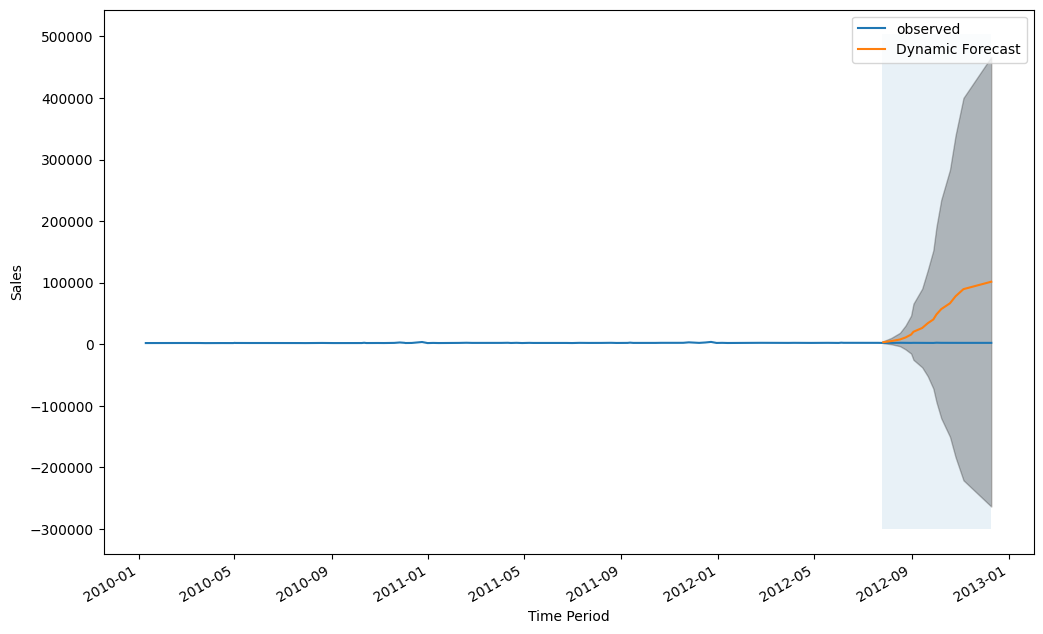

In [62]:
ax = y1['2010':].plot(label='observed', figsize=(12, 8))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)
ax.fill_between(pred_dynamic_ci.index,
pred_dynamic_ci.iloc[:, 0],
pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2012-7-26'), y1.index[-1],
alpha=.1, zorder=-1)
ax.set_xlabel('Time Period')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

**That looks good. Both the observed and predicted lines go together indicating nearly accurate prediction**

For future prediction the model is not that great because the error interval is way big. But if we just check the green line prediction this is almost like earlier years. If we look for may be first 2 weeks the prediction is way better
and error is also low

In [63]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = y1['2012-7-27':]
# Compute the Root mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Root Mean Squared Error of our forecasts is 49098.03


In [64]:
Residual= y_forecasted - y_truth
print("Residual for Store1",np.abs(Residual).sum())

Residual for Store1 571268.0200013318


In [65]:
# Get forecast 12 weeks ahead in future
pred_uc = results.get_forecast(steps=12)
# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()
pred_ci

,lower Weekly_Sales,upper Weekly_Sales
143,1339.323142,4539.947196
144,-1847.671473,8273.590471
145,-6870.573278,14837.115208
146,-12313.350786,26359.936802
147,-18912.138795,42736.234242
148,-33451.791876,57751.954755
149,-47988.461710,79876.369099
150,-65320.821237,106800.158355
151,-88906.722036,135525.272436
152,-114447.698428,170785.194144


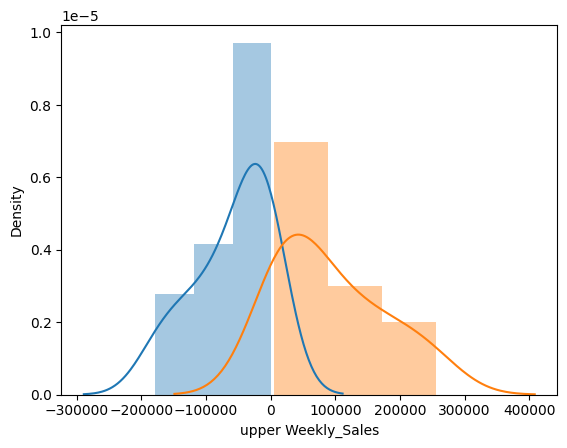

In [67]:
sns.distplot(pred_ci['lower Weekly_Sales'])
sns.distplot(pred_ci['upper Weekly_Sales']);

### i. **Inferences**

For future prediction the model is not that great because the error interval is way big. But if we just check the blue line prediction this is almost like earlier years. If we look for may be first 2 weeks the prediction is way better
and error is also low.

Store size and holidays have a direct relationship with high Walmart sales.

Each store has a unique prediction power. They can be separately analyzed to get prediction for each individual store

The Sales are very high during November and December and go down in January. So its better to employee more staff as casual employee in November and December and encourage permanent staff to take leaves during
January.

The predicted sales data can be used to analyse the sales pattern and accordingly

### j. **Future Possibilities of Project**

With growing technology and increasing consumer demand,Walmart can shift its focus on the e-commerce aspects of the business. Taking inspiration from Amazon’s business model, Walmart can grow its online retail
business massively and gather huge profits. With already established stores and warehouses, it is easier for the organization to create a nationwide reach, limiting the presence of physical stores and helping their customers
save on fuel costs by delivering goods at their doorstep. It also makes it a lot easier to identify consumer buying patterns. An important aspect of this study is also to try and understand customer buying behavior based on
regional and departmental sales. This customer segmentation can help the organization in creating and communicating targeted messages for customers belonging to a particular region, establishing better customer
relationships, focusing 57 on profitable regions, and identifying ways to improve products and services in specific regions or for specific customers. Another aspect that would be worth exploring with this study is identifying
trends with sales for each of the stores and predicting future trends based on the available sales data. Time series forecasting can be utilized (ARMA and ARIMA modeling) to predict future sales for each of the stores and
their respective departments.